## Задача

Узнать, используя базу данных NCBI Protein, есть ли у белка, который кодирует определенный ген, известная 3D-структура.

Предсказать посредством AlphaFold структуру белка, если она неизвестна.


In [ ]:
!pip install biopython >> None


ген geneid == 1499

Official Symbol CTNNB1


In [ ]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
Entrez.email = "A.N.Other@example.com"
import pandas as pd
import xml.etree.ElementTree as ET

In [ ]:
gid = 1499
gene_symbol = "CTNNB1"

поиск по базе протеины для гена "CTNNB1"

In [ ]:
aaa = Entrez.esearch(db='protein', term='CTNNB1[Gene Name] AND "1499"[entrezID] AND "human"[Organism] AND RefSeq[Keyword]', idtype="acc")
record_1 = Entrez.read(aaa)
aaa.close
record_1

{'Count': '22', 'RetMax': '20', 'RetStart': '0', 'IdList': ['NP_001317658.1', 'NP_001091679.1', 'NP_001091680.1', 'NP_001895.1', 'XP_054201292.1', 'XP_054201291.1', 'XP_054201290.1', 'XP_054201289.1', 'XP_054201288.1', 'XP_054201287.1', 'XP_054201286.1', 'XP_054201285.1', 'XP_047303439.1', 'XP_047303438.1', 'XP_047303437.1', 'XP_047303436.1', 'XP_047303435.1', 'XP_047303434.1', 'XP_047303433.1', 'XP_024309124.1'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'CTNNB1[Gene Name]', 'Field': 'Gene Name', 'Count': '2153', 'Explode': 'N'}, {'Term': '"1499"[All Fields]', 'Field': 'All Fields', 'Count': '137730', 'Explode': 'N'}, 'AND', {'Term': '"human"[Organism]', 'Field': 'Organism', 'Count': '2002188', 'Explode': 'Y'}, 'AND', {'Term': 'RefSeq[Keyword]', 'Field': 'Keyword', 'Count': '407381735', 'Explode': 'N'}, 'AND'], 'QueryTranslation': 'CTNNB1[Gene Name] AND "1499"[All Fields] AND "human"[Organism] AND RefSeq[Keyword]', 'ErrorList': {'FieldNotFound': ['entrezID'], 'PhraseNotFound

Кодируемые белки

In [ ]:
transcripts_list = [i for i in record_1['IdList'] if 'NP_' in i]
transcripts_list

['NP_001317658.1', 'NP_001091679.1', 'NP_001091680.1', 'NP_001895.1']

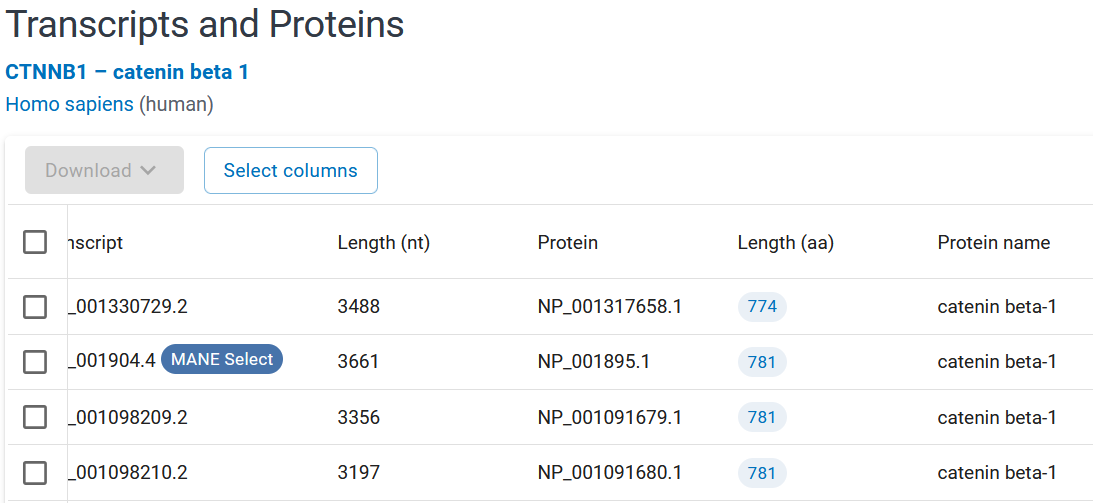

Итого 4 белка, проверим, есть ли структуры в базе NCBI

In [ ]:
for i in transcripts_list:
  handle = Entrez.esearch(db="structure", term=i)
  record = Entrez.read(handle)
  try:
    print(record['OutputMessage'])
  except KeyError:
    print('Для', i, 'Структуры нет')

Для NP_001317658.1 Структуры нет
Для NP_001091679.1 Структуры нет
Для NP_001091680.1 Структуры нет
Для NP_001895.1 Структуры нет


Визуализация  для протеина NP_001895.1 на сайте AlphaFold Protein Structure Database

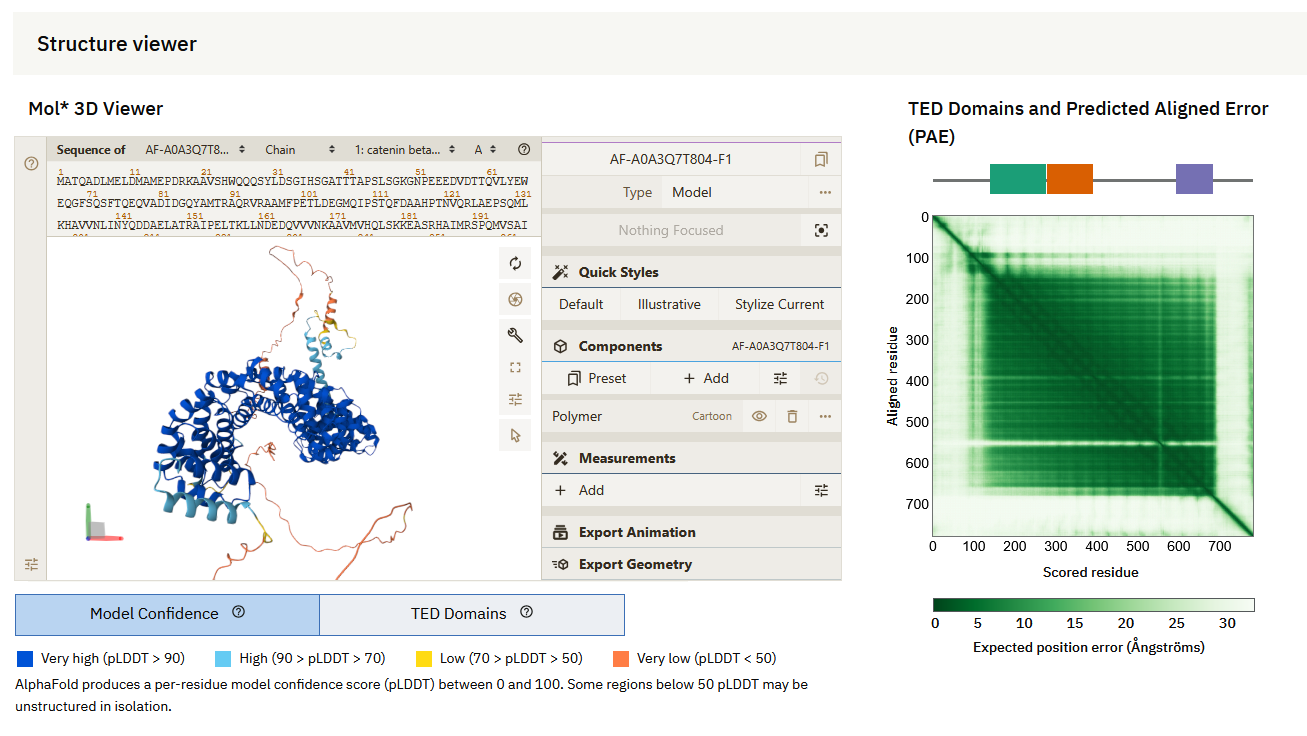

AlphaFold Notebook для NP_001895.1

In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGF'\
'SQSFTQEQVADIDGQYAMTRAQRVRAAMFPETLDEGMQIPSTQFDAAHPTNVQRLAEPSQMLKHAVVNLI'\
'NYQDDAELATRAIPELTKLLNDEDQVVVNKAAVMVHQLSKKEASRHAIMRSPQMVSAIVRTMQNTNDVET'\
'ARCTAGTLHNLSHHREGLLAIFKSGGIPALVKMLGSPVDSVLFYAITTLHNLLLHQEGAKMAVRLAGGLQ'\
'KMVALLNKTNVKFLAITTDCLQILAYGNQESKLIILASGGPQALVNIMRTYTYEKLLWTTSRVLKVLSVC'\
'SSNKPAIVEAGGMQALGLHLTDPSQRLVQNCLWTLRNLSDAATKQEGMEGLLGTLVQLLGSDDINVVTCA'\
'AGILSNLTCNNYKNKMMVCQVGGIEALVRTVLRAGDREDITEPAICALRHLTSRHQEAEMAQNAVRLHYG'\
'LPVVVKLLHPPSHWPLIKATVGLIRNLALCPANHAPLREQGAIPRLVQLLVRAHQDTQRRTSMGGTQQQF'\
'VEGVRMEEIVEGCTGALHILARDVHNRIVIRGLNTIPLFVQLLYSPIENIQRVAAGVLCELAQDKEAAEA'\
'IEAEGATAPLTELLHSRNEGVATYAAAVLFRMSEDKPQDYKKRLSVELTSSLFRTEPMAWNETADLGLDI'\
'GAQGEPLGYRQDDPSYRSFHSGGYGQDALGMDPMMEHEMGGHHPGADYPVDGLPDLGHAQDLMDGLPPGD'\
'SNQLAWFDTDL'#@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_58bb3
sequence MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGFSQSFTQEQVADIDGQYAMTRAQRVRAAMFPETLDEGMQIPSTQFDAAHPTNVQRLAEPSQMLKHAVVNLINYQDDAELATRAIPELTKLLNDEDQVVVNKAAVMVHQLSKKEASRHAIMRSPQMVSAIVRTMQNTNDVETARCTAGTLHNLSHHREGLLAIFKSGGIPALVKMLGSPVDSVLFYAITTLHNLLLHQEGAKMAVRLAGGLQKMVALLNKTNVKFLAITTDCLQILAYGNQESKLIILASGGPQALVNIMRTYTYEKLLWTTSRVLKVLSVCSSNKPAIVEAGGMQALGLHLTDPSQRLVQNCLWTLRNLSDAATKQEGMEGLLGTLVQLLGSDDINVVTCAAGILSNLTCNNYKNKMMVCQVGGIEALVRTVLRAGDREDITEPAICALRHLTSRHQEAEMAQNAVRLHYGLPVVVKLLHPPSHWPLIKATVGLIRNLALCPANHAPLREQGAIPRLVQLLVRAHQDTQRRTSMGGTQQQFVEGVRMEEIVEGCTGALHILARDVHNRIVIRGLNTIPLFVQLLYSPIENIQRVAAGVLCELAQDKEAAEAIEAEGATAPLTELLHSRNEGVATYAAAVLFRMSEDKPQDYKKRLSVELTSSLFRTEPMAWNETADLGLDIGAQGEPLGYRQDDPSYRSFHSGGYGQDALGMDPMMEHEMGGHHPGADYPVDGLPDLGHAQDLMDGLPPGDSNQLAWFDTDL
length 781


In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")

installing colabfold...
CPU times: user 99.2 ms, sys: 11.9 ms, total: 111 ms
Wall time: 35.1 s


In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-04-23 16:39:45,165 Running on GPU
2025-04-23 16:39:45,517 Found 5 citations for tools or databases
2025-04-23 16:39:45,517 Query 1/1: test_58bb3 (length 781)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


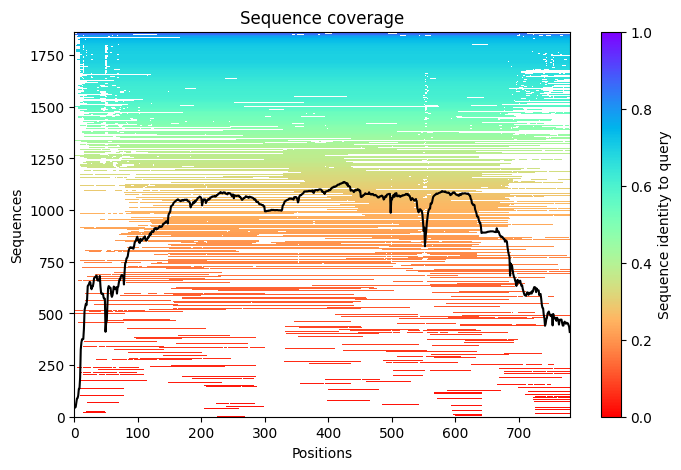

2025-04-23 16:39:48,588 Setting max_seq=512, max_extra_seq=1351
2025-04-23 16:42:40,399 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=78.9 pTM=0.701
2025-04-23 16:44:43,978 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=78.9 pTM=0.717 tol=5.74
2025-04-23 16:46:48,512 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=79.1 pTM=0.716 tol=3.38
2025-04-23 16:48:53,240 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=79.2 pTM=0.713 tol=2.6
2025-04-23 16:48:53,249 alphafold2_ptm_model_1_seed_000 took 527.9s (3 recycles)


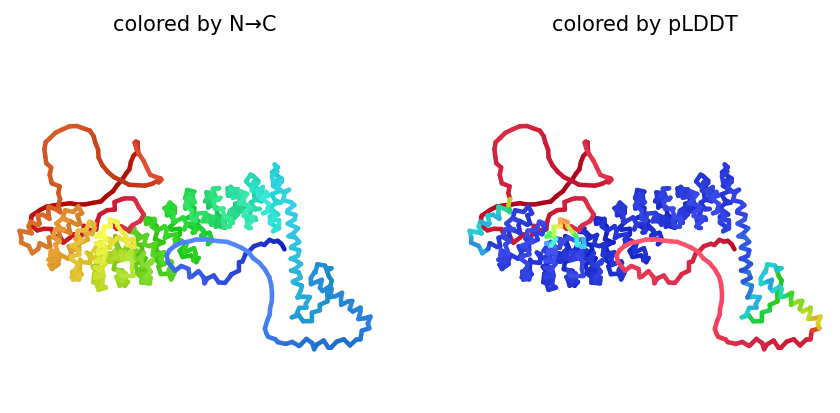

2025-04-23 16:50:57,818 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=78.3 pTM=0.686
2025-04-23 16:53:01,417 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=78.9 pTM=0.699 tol=8.45
2025-04-23 16:55:05,701 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=78.9 pTM=0.701 tol=4.57
2025-04-23 16:57:09,293 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=79 pTM=0.702 tol=1.99
2025-04-23 16:57:09,302 alphafold2_ptm_model_2_seed_000 took 495.2s (3 recycles)


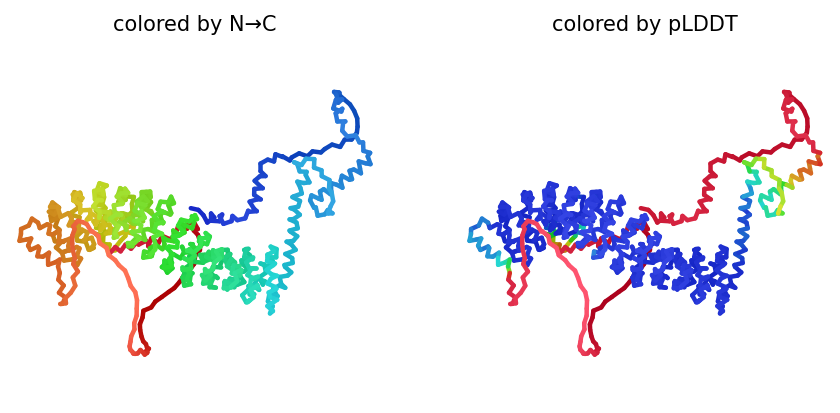

2025-04-23 16:59:13,616 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=79.4 pTM=0.694
2025-04-23 17:01:16,913 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=79.9 pTM=0.711 tol=5.89
2025-04-23 17:03:20,926 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=80 pTM=0.708 tol=2.52
2025-04-23 17:05:23,851 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=80.2 pTM=0.711 tol=1.9
2025-04-23 17:05:23,863 alphafold2_ptm_model_3_seed_000 took 493.8s (3 recycles)


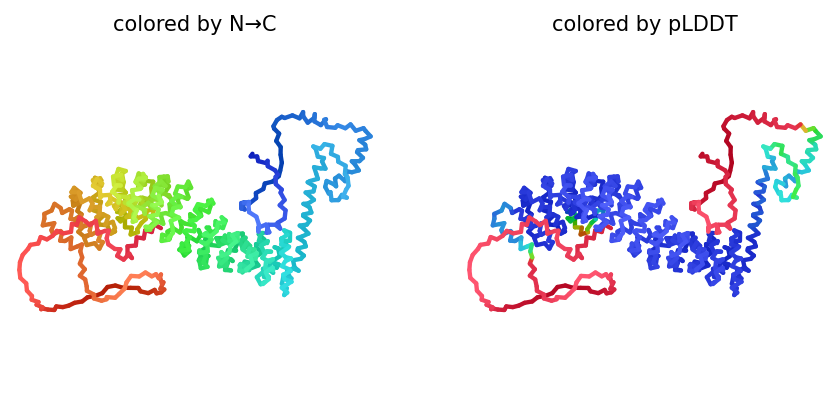

2025-04-23 17:07:28,336 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=78.3 pTM=0.704
2025-04-23 17:09:32,708 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=78.9 pTM=0.715 tol=3.51
2025-04-23 17:11:38,007 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=78.9 pTM=0.713 tol=2.44
2025-04-23 17:13:40,898 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=78.9 pTM=0.713 tol=2.59
2025-04-23 17:13:40,902 alphafold2_ptm_model_4_seed_000 took 496.1s (3 recycles)


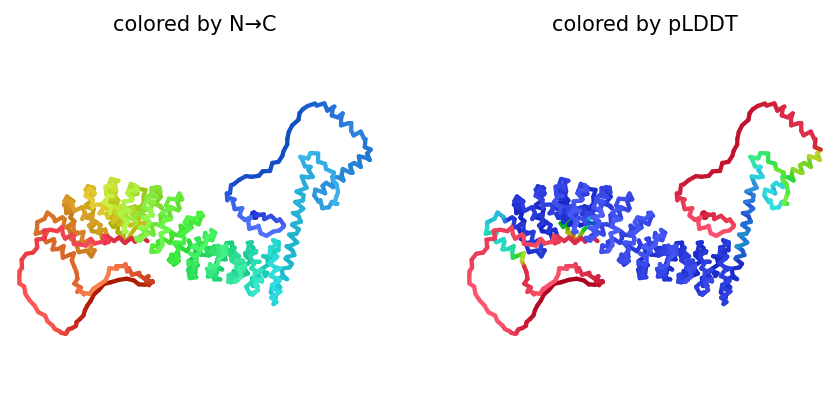

2025-04-23 17:15:43,896 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=79.7 pTM=0.709
2025-04-23 17:17:48,196 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=79.8 pTM=0.716 tol=5.72
2025-04-23 17:19:52,353 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=79.6 pTM=0.715 tol=2.81
2025-04-23 17:21:54,991 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=79.7 pTM=0.716 tol=2.17
2025-04-23 17:21:55,000 alphafold2_ptm_model_5_seed_000 took 493.3s (3 recycles)


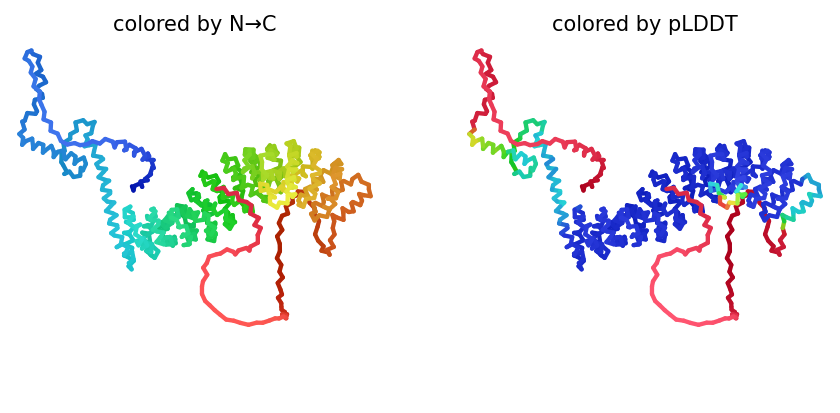

2025-04-23 17:21:55,866 reranking models by 'plddt' metric
2025-04-23 17:21:55,866 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=80.2 pTM=0.711
2025-04-23 17:21:55,867 rank_002_alphafold2_ptm_model_5_seed_000 pLDDT=79.7 pTM=0.716
2025-04-23 17:21:55,867 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=79.2 pTM=0.713
2025-04-23 17:21:55,867 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=79 pTM=0.702
2025-04-23 17:21:55,867 rank_005_alphafold2_ptm_model_4_seed_000 pLDDT=78.9 pTM=0.713
2025-04-23 17:21:58,623 Done


0

In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

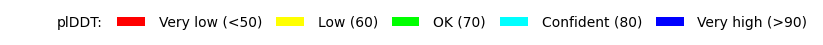

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()